# <center> NIRS <center> MultiOutput
***
# Table of Contents
* [READING THE DATASET INTO PYTHON](#READING-THE-DATASET-INTO-PYTHON)
* [DATA EDITING](#DATA-EDITING)
    * [Creating dummy variables (One-Hot Encode)](#Creating-dummy-variables-(One-Hot-Encode))
    * [Creating training and testing datasets](#Creating-training-and-testing-datasets)
* [PARTIAL LEAST SQUARE](#PARTIAL-LEAST-SQUARE)
    * [Training (GridSearch)](#Training-(GridSearch))
    * [Testing](#Testing)
* [RIDGE REGRESSION](#RIDGE-REGRESSION)
    * [Training (GridSearch)](#Training-(GridSearch))
    * [Testing](#Testing)
* [NEURAL NETWORK](#NEURAL-NETWORK)
    * [Data pre-processing](#Data-pre-processing)
    * [Training (GridSearch)](#Training-(GridSearch))
    * [Testing](#Testing)
***

## READING THE DATASET INTO PYTHON

In [12]:
import pandas as pd
import numpy as np
import warnings
# warnings.filterwarnings('ignore')
df = pd.read_excel('Datasets/Lucas/dados_nirs_lucas.xlsx')

In [13]:
# Private libary
import cmls

## DATA EDITING

In [14]:
# Transform all feautere names to string
df.columns = df.columns.map(str)

## Creating training and testing datasets

In [34]:
# Select all NIRS data as x
x = df.loc[:,'12493.238':]

In [30]:
# Add Categoria feature
x = x.join(df.loc[:,['Categoria']])

# One-Hot Encode categorical features
x = pd.get_dummies(x, drop_first=False)

In [31]:
# Non NIRS features
print(df.loc[:,:'CD CNF'].columns.tolist())

['Animal', 'Coleta', 'Aluno', 'Experimento', 'Categoria', 'Dieta', 'Status fisiologico', 'Peso corporal kg', 'Consumo MS kg/dia', 'Consumo MO kg/dia', 'Consumo PB kg/dia', 'Consumo FDN kg/dia', 'Consumo EE kg/dia', 'Consumo CNF kg/dia', 'Consumo de FDNi kg/dia', 'Fezes MS kg/dia', 'Fezes MO kg/dia', 'Fezes PB kg/dia', 'Fezes FDN kg/dia', 'Fezes EE kg/dia', 'Fezes CNF kg/dia', 'TD MO', 'TD PB', 'TD FDN', 'TD EE', 'TD CNF', 'TF MO', 'TF PB', 'TF FDN', 'TF EE', 'TF CNF', 'TF FDNpd', 'CD MS', 'CD MO', 'CD PB', 'CD FDN', 'CD EE', 'CD CNF']


In [32]:
# Response variable vector
target_features = ['Consumo MS kg/dia', 'TD PB', 'TF PB', 'CD FDN']
y = df[target_features]

In [35]:
y = df['TD PB']

In [36]:
# Split the data set into training (70%) and testing (30%)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, shuffle=True, random_state=40)
print("N. samples training %s , N. samples testing %s" % (x_train.shape[0], x_test.shape[0]))

N. samples training 186 , N. samples testing 81


# PARTIAL LEAST SQUARE

##  Training (GridSearch)

In [10]:
# GridSearch using k-fold cross-validation
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'n_components':[1, 3, 5]}
pls = PLSRegression()
pls = GridSearchCV(pls, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
pls.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=PLSRegression(),
             param_grid={'n_components': [1, 3, 5]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'))

In [11]:
# Matrics - training
pd.DataFrame({'N. Components': pls.cv_results_["param_n_components"], 
              'R2': pls.cv_results_["mean_test_r2"], 
              'MAE': abs(pls.cv_results_['mean_test_neg_mean_absolute_error']),
              'RMSE': abs(pls.cv_results_['mean_test_neg_root_mean_squared_error'])})

,N. Components,R2,MAE,RMSE
0,1,-0.017726,10.001146,12.740323
1,3,0.023302,9.327968,12.493303
2,5,0.023212,9.478155,12.467623


## Testing

In [12]:
# Print best number of components and RMSE, and testing the best model using the test set
print("Best N. Components: %s, RMSE: %.6f" % (pls.best_params_['n_components'], abs(pls.best_score_)))
ypred = pls.best_estimator_.predict(x_test)

Best N. Components: 5, RMSE: 12.467623


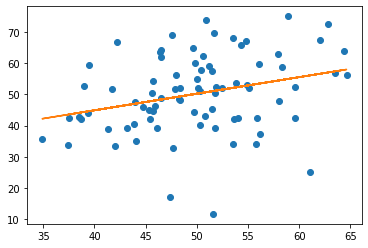

In [13]:
# Scatter plot - predicted and observed
import matplotlib.pyplot as plt
import numpy as np
ypred = np.ravel(ypred)
plt.plot(ypred, y_test, 'o')
m, b = np.polyfit(ypred, y_test, 1)
plt.plot(ypred, m*ypred + b)

In [ ]:
# Metrics - testing
from sklearn.metrics import *

pd.DataFrame({'N. Components': [pls.best_params_['n_components']], 
              'R2': r2_score(y_test, ypred), 
              'MAE': [mean_absolute_error(y_test, ypred)],
              'RMSE': [mean_squared_error(y_test, ypred, squared=False)]})

# SUPPORT VECTOR MACHINE

In [20]:
from sklearn.svm import SVR
from sklearn.multioutput import RegressorChain

svr = SVR()
svr_model = RegressorChain(svr)

svr_model.fit(x_train, y_train)
svr_preds = svr_model.predict(x_test)
cmls.evalute_model(y_test, svr_preds)

IndexError: tuple index out of range

In [99]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

svr = SVR()
svr_model = MultiOutputRegressor(svr, n_jobs=-1)

svr_model.fit(x_train, y_train)
svr_preds = svr_model.predict(x_test)
cmls.evalute_model(y_test, svr_preds)

,R2,MAE,RMSE
Teste,0.087072,3.687592,4.803699


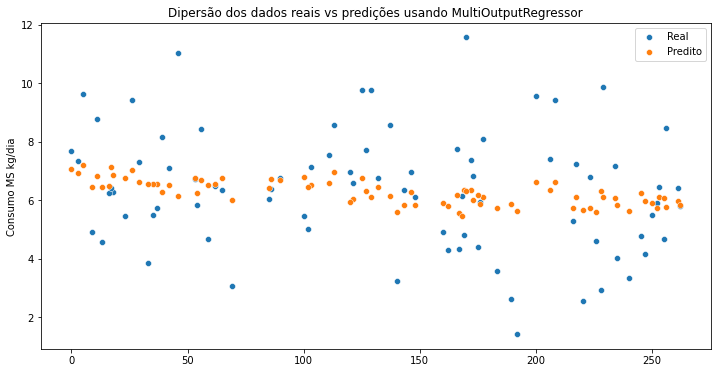

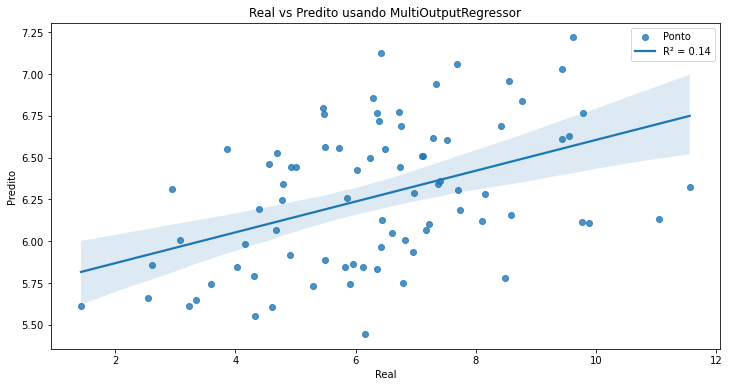

In [31]:
cmls.plot_graphical_analysis(y_test.iloc[:, 0], svr_preds[:, 0], svr_model)

In [16]:
y_test

,Consumo MS kg/dia,TD PB,TF PB,CD FDN
208,9.432997,7.123244,8.582565,74.959423
235,4.018938,12.228666,6.326041,42.071424
100,5.456952,9.234744,8.970731,40.093267
11,8.774905,10.598406,14.563240,54.119909
18,6.280935,10.189565,10.506493,59.461427
...,...,...,...,...
127,7.710313,14.664137,8.974352,44.650003
129,9.760199,13.887121,8.491273,48.505494
256,8.482097,6.754417,11.925040,65.687081
162,4.312271,5.723337,8.130000,53.551821


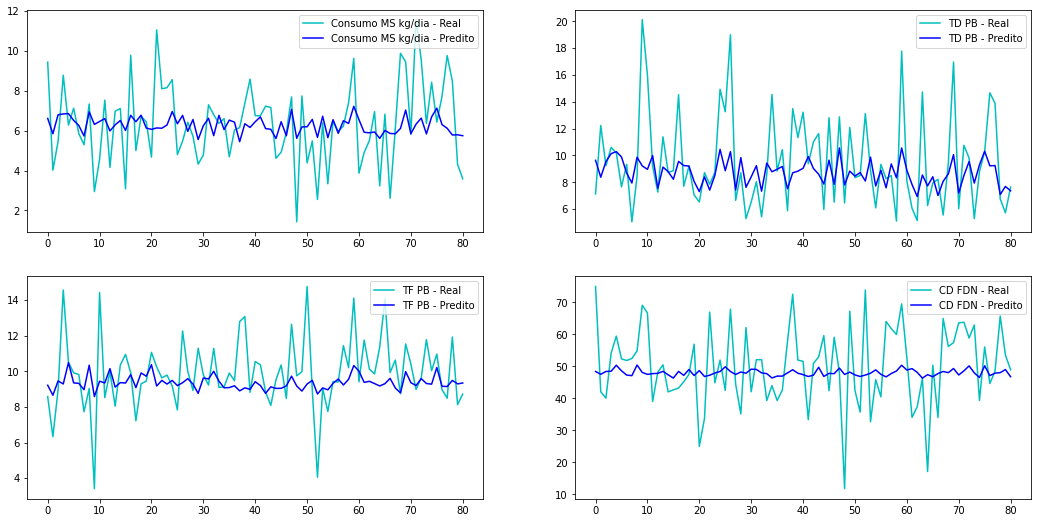

In [30]:
import matplotlib.pyplot as plt
x_ax = range(len(x_test))
fig = plt.figure(figsize=(18,9))
num_of_targets = len(target_features)

for i in range(num_of_targets):
    fig.add_subplot(num_of_targets//2, num_of_targets//2, i + 1)   
    plt.plot(x_ax, y_test.iloc[:,i], label=target_features[i]+" - Real", color='c')
    plt.plot(x_ax, svr_preds[:,i], label=target_features[i]+" - Predito", color='b')
    plt.legend(loc="upper right")

plt.legend()
plt.show()

In [21]:
from sklearn.svm import SVR
svr_model = SVR()

svr_model.fit(x_train, y_train)
svr_preds = svr_model.predict(x_test)
cmls.evalute_model(y_test, svr_preds)

,R2,MAE,RMSE
Teste,0.14092,2.191742,3.165511


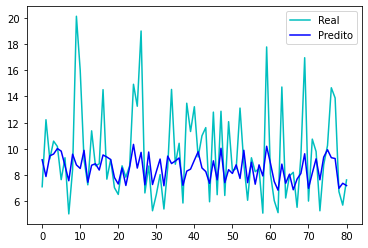

In [22]:
import matplotlib.pyplot as plt
x_ax = range(len(x_test))

plt.plot(x_ax, y_test, label="Real", color='c')
plt.plot(x_ax, svr_preds, label="Predito", color='b')

plt.legend()
plt.show()

##  Hyperparameters search

In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
def tune_svt(params):
    from sklearn.model_selection import cross_val_score
    kernel = params[0]
    degree = params[1]
    gamma = params[2]
    coef0 = params[3]
    tol = params[4]
    C = params[5]
    
    print(params, '\n')
    
    svr_model = SVR(kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, tol=tol, C=C)

    r2 = cross_val_score(svr_model, x_train, y_train, cv=3, scoring ='r2')
    
    return -r2.mean()

space = [
    ['linear', 'poly', 'rbf', 'sigmoid'], #kernal
    (1, 12), #degree
    ['scale', 'auto'], # gamma
    (0.05, 3.0), # coef0
    (0.000001, 0.01), # tol
    (0.1, 3.0)] # C

In [39]:
%%time
from skopt import gp_minimize
svr_best_params = gp_minimize(tune_svt, space, random_state=0, verbose=True, n_calls=100, n_random_starts=20, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
['rbf', 10, 'scale', 2.5493926294131706, 0.0062360134041629395, 1.2147069511488298] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1059
Function value obtained: -0.1810
Current minimum: -0.1810
Iteration No: 2 started. Evaluating function at random point.
['poly', 2, 'auto', 1.4591120960979826, 0.00812187511902616, 1.4919337998876667] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0862
Function value obtained: 0.0025
Current minimum: -0.1810
Iteration No: 3 started. Evaluating function at random point.
['poly', 10, 'auto', 1.9621070225510322, 0.0036830471568656403, 2.875749960963835] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1102
Function value obtained: -0.0524
Current minimum: -0.1810
Iteration No: 4 started. Evaluating function at random point.
['linear', 11, 'auto', 2.412686718339951, 0.005205254318032499, 2.068750637344985] 

Iteration No: 4

/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 0.9735
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 83 started. Searching for the next optimal point.
['rbf', 12, 'scale', 0.05, 1e-06, 2.5251896757713435] 

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 1.0154
Function value obtained: -0.2372
Current minimum: -0.3016
Iteration No: 84 started. Searching for the next optimal point.
['rbf', 12, 'scale', 0.05, 0.00241318884107921, 3.0] 

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 1.0592
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 85 started. Searching for the next optimal point.
['rbf', 12, 'scale', 0.05, 0.0030440509361382784, 3.0] 

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 1.0378
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 86 started. Searching for the next optimal poi

/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 0.9833
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 91 started. Searching for the next optimal point.
['rbf', 12, 'scale', 0.05, 0.01, 3.0] 



/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 1.0776
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 92 started. Searching for the next optimal point.
['rbf', 1, 'scale', 0.05, 0.006742429053833933, 3.0] 

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 1.0440
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 93 started. Searching for the next optimal point.
['rbf', 2, 'scale', 3.0, 0.01, 3.0] 

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 1.1036
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 94 started. Searching for the next optimal point.
['rbf', 3, 'scale', 0.05, 0.01, 3.0] 

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 1.2001
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 95 started. Searching for the next optimal point.
['rbf', 12, 'scale', 0.05, 0.01,

/home/caio/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 1.0619
Function value obtained: -0.2484
Current minimum: -0.3016
Iteration No: 96 started. Searching for the next optimal point.
['rbf', 12, 'auto', 0.05, 0.0034343392753588575, 1.258183473955798] 

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1.0823
Function value obtained: 0.0156
Current minimum: -0.3016
Iteration No: 97 started. Searching for the next optimal point.
['sigmoid', 1, 'scale', 0.05, 0.0068914569590440115, 1.2750375393841844] 

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 1.1394
Function value obtained: 0.0344
Current minimum: -0.3016
Iteration No: 98 started. Searching for the next optimal point.
['sigmoid', 12, 'auto', 0.05, 0.008920577468821965, 1.917789645016403] 

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 1.2398
Function value obtained: 0.0208
Current minimum: -0.3016
Iteration No:

In [26]:
svr_best_params.x

['linear',
 6,
 'auto',
 1.8215484326388047,
 0.008321501992693332,
 0.8347510176492211]

In [27]:
from sklearn.svm import SVR
svr_model = SVR(kernel='linear', degree=1, gamma='scale', coef0=1.6298545626753969, tol=0.002556173522948577, C = 0.5613745354785382)

svr_model.fit(x_train, y_train)
svr_preds = svr_model.predict(x_test)
cmls.evalute_model(y_test, svr_preds)

,R2,MAE,RMSE
Teste,0.237248,2.180494,2.982762


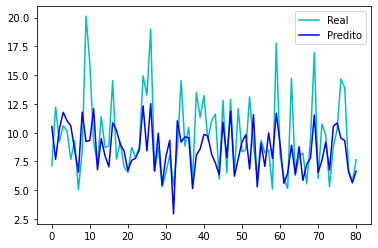

In [28]:
import matplotlib.pyplot as plt
x_ax = range(len(x_test))

plt.plot(x_ax, y_test, label="Real", color='c')
plt.plot(x_ax, svr_preds, label="Predito", color='b')

plt.legend()
plt.show()

# K-NEAREST NEIGHBORS

In [86]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=23, n_jobs=-1)
knn_model.fit(x_train, y_train)

knn_preds = knn_model.predict(x_test)
knn_train_preds = knn_model.predict(x_train)

In [87]:
pd.DataFrame(np.concatenate((knn_preds.reshape(81,1), np.array(y_test).reshape(81,1)), axis=1)[10:20], columns=['Predito', 'Real'])

,Predito,Real
0,8.931268,15.989929
1,9.776228,9.184520
2,8.688612,7.267690
3,9.158326,11.382884
4,9.433858,8.722530
5,8.007962,8.869146
6,11.064217,14.521393
7,9.649156,7.701799
8,9.098185,9.189468
9,9.217570,7.050209


In [91]:
cmls.evalute_model( y_test, knn_preds, y_train, knn_train_preds)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# RANDOM FOREST

In [240]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=3, random_state=40, n_jobs=-1)
rf_model.fit(x_train,  np.ravel(y_train))

rf_preds = rf_model.predict(x_test)
rf_train_preds = rf_model.predict(x_train)

from sklearn.metrics import mean_squared_error
print(f'RMSE: {mean_squared_error(y_test, rf_preds, squared=False)}')

RMSE: 11.495219914788228


In [241]:
pd.DataFrame(np.concatenate((rf_preds.reshape(81,1), np.array(y_test).reshape(81,1)), axis=1)[10:20], columns=['Predito', 'Real'])

,Predito,Real
0,57.672446,66.710369
1,42.399187,39.048849
2,57.223049,48.193604
3,52.192225,50.490850
4,50.912284,42.025374
5,40.594441,42.666645
6,47.587759,43.222300
7,59.851305,45.207388
8,42.966927,47.498887
9,52.611038,56.932389


In [242]:
evalute_model(rf_preds, y_test, rf_train_preds, y_train)

,R2,MAE,RMSE
Teste,0.134577,9.080434,11.495220
Treino,0.578489,4.914994,8.234105


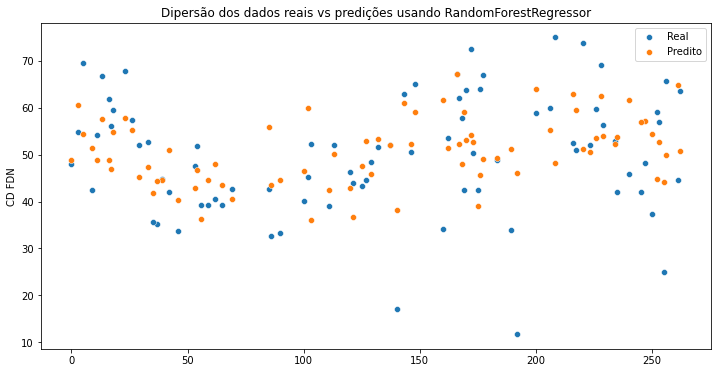

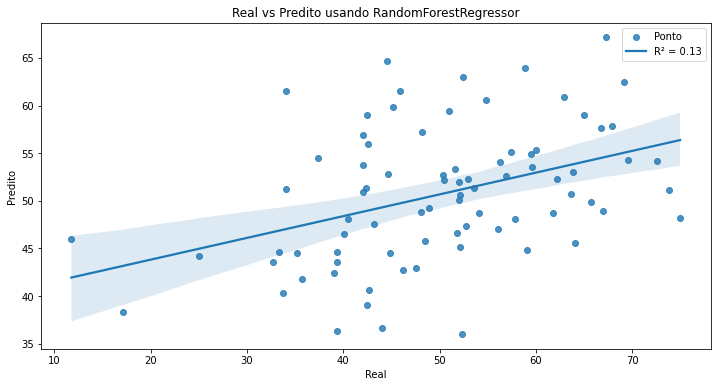

In [244]:
plot_graphical_analysis(y_test, rf_preds, rf_model)

# RIDGE REGRESSION

## Training (GridSearch)

In [75]:
# GridSearch using k-fold cross-validation
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'alpha':[0, 0.3, 0.8]}
rr = Lasso()
rr = GridSearchCV(rr, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
rr.fit(x_train, y_train)

/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:681: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/caio/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.914e+01, tolerance: 1.824e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV i

GridSearchCV(cv=3, estimator=Lasso(), param_grid={'alpha': [0, 0.3, 0.8]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'))

In [76]:
# GridSearch using k-fold cross-validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'max_depth':[10, 20]}
rr = DecisionTreeRegressor()
rr = GridSearchCV(rr, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
rr.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 20]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'))

In [77]:
# Matrics - training
pd.DataFrame({'Alpha': rr.cv_results_["param_alpha"], 
              'R2': rr.cv_results_["mean_test_r2"], 
              'MAE': abs(rr.cv_results_['mean_test_neg_mean_absolute_error']),
              'RMSE': abs(rr.cv_results_['mean_test_neg_root_mean_squared_error'])})

KeyError: 'param_alpha'

## Testing

In [55]:
# Print best alpha and RMSE, and testing the best model using the test set
print("Best Alpha: %.1f, RMSE: %.6f" % (rr.best_params_['alpha'], abs(rr.best_score_)))
ypred = rr.best_estimator_.predict(x_test)
ypred = rr.best_estimator_.predict(x_train)

Best Alpha: 0.3, RMSE: 12.566016


ValueError: x and y must have same first dimension, but have shapes (186,) and (81, 1)

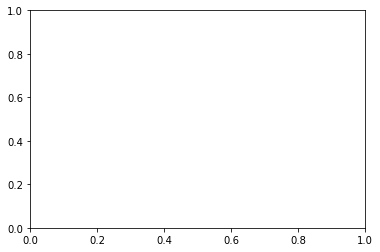

In [56]:
# Scatter plot - predicted and observed
import matplotlib.pyplot as plt
import numpy as np
ypred = np.ravel(ypred)
plt.plot(ypred, y_test, 'o')
m, b = np.polyfit(ypred, y_test, 1)
plt.plot(ypred, m*ypred + b)

In [24]:
# Metrics - testing
from sklearn.metrics import *

pd.DataFrame({'Alpha': [rr.best_params_['alpha']], 
              'R2': r2_score(y_test, ypred), 
              'MAE': [abs(mean_absolute_error(y_test, ypred))],
              'RMSE': [abs(mean_squared_error(y_test, ypred, squared=False))]})

ValueError: Found input variables with inconsistent numbers of samples: [120, 280]

# NEURAL NETWORK

## Data pre-processing

In [93]:
# Center and Standardize all features (force mean=0 and standard deviation=1)
x_std = x
x_std = (x_std - x_std.mean()) / x_std.std() # Subtract mean and divide by standard deviation
x_std

,12493.238,12489.381,12485.523,12481.666,12477.809,12473.952,12470.095,12466.238,12462.381,12458.523,...,3633.415,3629.557,3625.7,3621.843,3617.986,3614.129,3610.272,3606.415,3602.558,3598.7
0,-0.971853,-0.975338,-0.979259,-0.974991,-0.965919,-0.986035,-1.034307,-1.034204,-0.969116,-0.921061,...,0.340473,0.688463,0.819742,0.509423,0.660676,0.811626,0.119692,0.600045,1.979225,2.501502
1,-1.577410,-1.538785,-1.514164,-1.524268,-1.559769,-1.573520,-1.556337,-1.545328,-1.550890,-1.561879,...,0.460509,0.872545,0.696110,-0.419849,-0.919264,-0.719948,-0.352404,0.011646,-0.105073,-0.526305
2,-1.464349,-1.446053,-1.446982,-1.484071,-1.529664,-1.550347,-1.540800,-1.513357,-1.503986,-1.511109,...,1.584898,1.472407,1.011563,0.211140,-0.470306,-0.733967,-0.792885,-0.705540,-0.732995,-0.988885
3,-2.033286,-2.013262,-2.036084,-2.101294,-2.132841,-2.081392,-2.021375,-2.025061,-2.036171,-2.001991,...,-0.813573,0.042750,-0.021965,-0.729674,-0.620016,-0.380774,-0.333882,0.030223,0.368676,0.309597
4,-0.969043,-0.983221,-0.970071,-0.984674,-1.040669,-1.062676,-1.031669,-0.988076,-0.950001,-0.930261,...,1.732473,1.576646,1.334114,0.238638,-0.445796,-0.089074,0.026985,0.168938,0.070313,-0.153239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,0.645306,0.633396,0.667808,0.691411,0.651233,0.615765,0.609192,0.621458,0.634014,0.596226,...,-1.087766,-1.239723,-1.394215,-1.409483,-0.657931,0.158109,0.940679,0.999627,0.276723,-0.333437
263,0.981246,0.973011,0.953493,0.938706,0.927839,0.923290,0.899504,0.839159,0.811861,0.864709,...,-1.601851,-2.204386,-2.000821,-0.300792,0.686666,0.414330,0.212325,0.059453,0.489400,0.192065
264,0.854955,0.794811,0.739588,0.747087,0.782764,0.768207,0.680324,0.609329,0.656466,0.756746,...,-1.279810,-2.022717,-1.983041,-1.575008,-0.833642,-0.317021,-0.014201,-0.119777,-0.486251,-0.599041
265,0.601680,0.589719,0.575024,0.576648,0.626220,0.646341,0.591647,0.586469,0.646456,0.642037,...,-1.511728,-1.683650,-1.886841,-1.067758,0.474138,1.341074,0.986245,-0.195027,-0.854755,-0.858878


In [94]:
# Response variable vector
y = df[["CD FDN"]]
y

,CD FDN
0,48.020838
1,56.095593
2,53.092602
3,54.817350
4,64.944856
...,...
262,63.597757
263,45.851922
264,10.417453
265,18.125828


In [95]:
# Split the data set into training (70%) and testing (30%)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size=0.30, shuffle=True, random_state=4)
print("N. samples training %s , N. samples testing %s" % (x_train.shape[0], x_test.shape[0]))

N. samples training 186 , N. samples testing 81


##  Training (GridSearch)

In [ ]:
# GridSearch using k-fold cross-validation
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
nfolds = 3
metrics = ('r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error')
parameters = {'activation':('relu', 'tanh'), 
              'hidden_layer_sizes': [(3,),(5,),(10,)],
              'random_state':[40]}

nn = MLPRegressor()
nn = GridSearchCV(nn, parameters, scoring=metrics, cv=nfolds, refit = metrics[2], return_train_score = True)
nn.fit(x_train, np.ravel(y_train))

In [98]:
pd.DataFrame({'Activation': nn.cv_results_["param_activation"],
              'Layer Sizes': nn.cv_results_['param_hidden_layer_sizes'],
              'R2': nn.cv_results_["mean_test_r2"], 
              'MAE': abs(nn.cv_results_['mean_test_neg_mean_absolute_error']),
              'RMSE': abs(nn.cv_results_['mean_test_neg_root_mean_squared_error'])})

,Activation,Layer Sizes,R2,MAE,RMSE
0,relu,"(3,)",-6.522277,27.925503,33.633517
1,relu,"(5,)",-5.018888,24.213709,29.976535
2,relu,"(10,)",-5.320145,25.309131,30.604210
3,tanh,"(3,)",-16.542293,49.813293,51.374267
4,tanh,"(5,)",-16.122275,49.132702,50.731736
5,tanh,"(10,)",-15.899153,48.708890,50.399608


## Testing

In [99]:
# Print best activation function, layer size, and RMSE, and testing the best model using the test set
print("Best Activation: %s, Layer Size: %s, RMSE: %.6f" % (nn.best_params_['activation'], nn.best_params_['hidden_layer_sizes'], abs(nn.best_score_)))
ypred = nn.best_estimator_.predict(x_test)

Best Activation: relu, Layer Size: (5,), RMSE: 29.976535


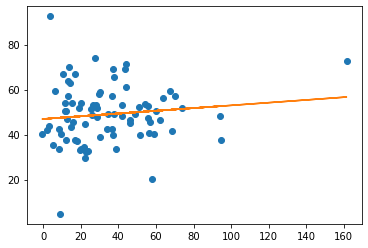

In [100]:
# Scatter plot - predicted and observed
import matplotlib.pyplot as plt
import numpy as np
ypred = np.ravel(ypred)
plt.plot(ypred, y_test, 'o')
m, b = np.polyfit(ypred, y_test, 1)
plt.plot(ypred, m*ypred + b)

In [101]:
# Metrics - testing
from sklearn.metrics import *

pd.DataFrame({'Activation': [nn.best_params_['activation']],
              'Layer Size': [nn.best_params_['hidden_layer_sizes']],
              'R2': r2_score(y_test, ypred), 
              'MAE': [abs(mean_absolute_error(y_test, ypred))],
              'RMSE': [abs(mean_squared_error(y_test, ypred, squared=False))]})

,Activation,Layer Size,R2,MAE,RMSE
0,relu,"(5,)",-4.725426,25.169789,31.101654
